## Text classification

NLP Model with DistilBERT, only code.

In [42]:
# Import neccesay libraries

from datasets import load_dataset
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    accuracy_score,
    f1_score
)
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [43]:
# Auxiliary functions

# Define a function to compute the metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc, "f1": f1
    }

# Define a function to show the confusion matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [44]:
# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use CPU
use_cpu = True if device.type == "cpu" else False

# Show the device being used and whether CPU is being used
print(f"Using device: {device}, CPU mode: {use_cpu}")

# Load the dataset
dataset = load_dataset("emotion")

# Number of classes in the dataset
num_labels = len(dataset["train"].features["label"].names)

# Show the number of classes
print(f"Number of classes: {num_labels}")

# Load the checkpoint for the model and the tokenizer
model_ckpt = "distilbert-base-uncased"

# Route to save and load the model
model_path = f"models/{model_ckpt}-finetuned"

Using device: cuda, CPU mode: False
Number of classes: 6


In [45]:
# Initialize the tokenizer and model

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)

In [46]:
# Auxiliary functions

# Define a function to tokenize the dataset
def tokenize_function(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [47]:
# Tokenize the dataset
dataset_encoded = dataset.map(tokenize_function, batched=True, batch_size=None)

In [48]:
# Variables for training
batch_size = 16
logging_steps = len(dataset_encoded["train"]) // batch_size

# Define training arguments
training_args = TrainingArguments(
    output_dir = model_path,
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    disable_tqdm = False,
    logging_steps = logging_steps,
    log_level = "error",
    use_cpu = use_cpu,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [49]:
# Initialize the Trainer
trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = dataset_encoded["train"],
    eval_dataset = dataset_encoded["validation"],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
)

/tmp/ipykernel_5972/339483361.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [50]:
# Train the model
trainer.train()

Step,Training Loss
1000,0.478600
2000,0.145700


TrainOutput(global_step=2000, training_loss=0.31215079498291015, metrics={'train_runtime': 155.971, 'train_samples_per_second': 205.166, 'train_steps_per_second': 12.823, 'total_flos': 720342861696000.0, 'train_loss': 0.31215079498291015, 'epoch': 2.0})

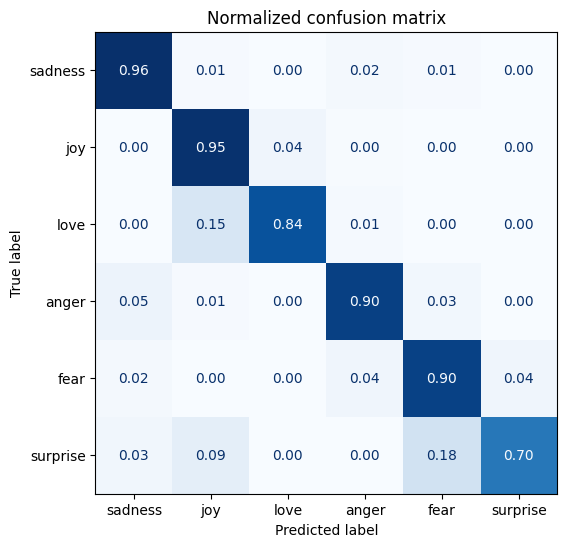

In [51]:
# Predict on the test set
preds_output = trainer.predict(dataset_encoded["test"])

# Get the predictions
y_preds = np.argmax(preds_output.predictions, axis=1)

# Get the true labels
y_valid = dataset_encoded["test"]["label"]

# Get the labels from the dataset
labels = dataset_encoded["test"].features["label"].names

# Show the confusion matrix
plot_confusion_matrix(y_preds, y_valid, labels)

In [52]:
# Save the model and tokenizer
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

# Load the model and tokenizer in the pipeline
classifier = pipeline("text-classification", model = model_path, tokenizer = model_path)

/home/notrootusername/Documents/Desarrollo/research-machine-learning/venv/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


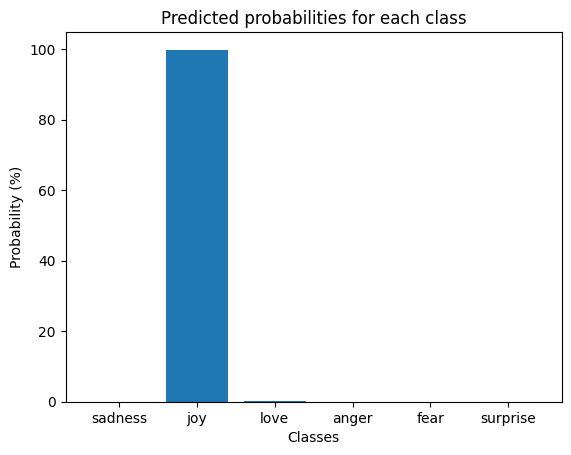

In [53]:
# Test the classifier with a sample text

# Test text for classification
test_text = "I feel happy today!"

# Get the predicted probabilities for each class
pred = classifier(test_text, return_all_scores=True)

# Show the predicted probabilities
preds_df = pd.DataFrame(pred[0])
plt.bar(labels, preds_df["score"] * 100, color="C0")
plt.title("Predicted probabilities for each class")
plt.xlabel("Classes")
plt.ylabel("Probability (%)")
plt.show()